# Single-Cell RNA-seq Clustering Analysis Notebook

**Author** - Clarence Mah
<br>
**Email** - ckmah.ucsd.edu

## Summary
The goal of this notebook is to provide a standard single-cell RNA-seq analysis workflow for pre-processing, identifying sub-populations of cells by clustering, and exploring biomarkers to explain intra-population heterogeneity. The workflow is modeled after the [Seurat Guided Clustering Tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html)<sup>[[1]](https://www.nature.com/articles/nbt.3192)</sup> and performs all analyses using the [scanpy](https://github.com/theislab/scanpy)<sup>[[2]](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-017-1382-0)</sup> library. 

### Use Case
Single-cell RNA sequencing (scRNA-seq) has emerged as a popular method to profile gene expression at the resolution of individual cells. Compared to traditional RNA-seq collected from bulk cells or tissue, scRNA-seq enables users to capture cell-by-cell transcriptomic variability. This information can then be used to define and characterize heterogeneity within a population of cells, from identifying known cell types to discovering novel ones. Here we examine a [peripheral blood mononuclear cells](https://en.wikipedia.org/wiki/Peripheral_blood_mononuclear_cell) (PBMCs) dataset, which consists of many immune cell types including T-cells, B-cells, NK-cells, macrophages, and dendritic cells.

### Dataset
This notebook analyzes a dataset of [3K Peripheral Blood Mononuclear Cells (PBMCs) from a Healthy Donor](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k) available from 10X Genomics, sequenced on the Illumina NextSeq 500. 
- **Matrix Data File**: 10X Genomics formatted single-cell RNA-seq count matrix of 2,700 single PBMCs

## Analysis Overview
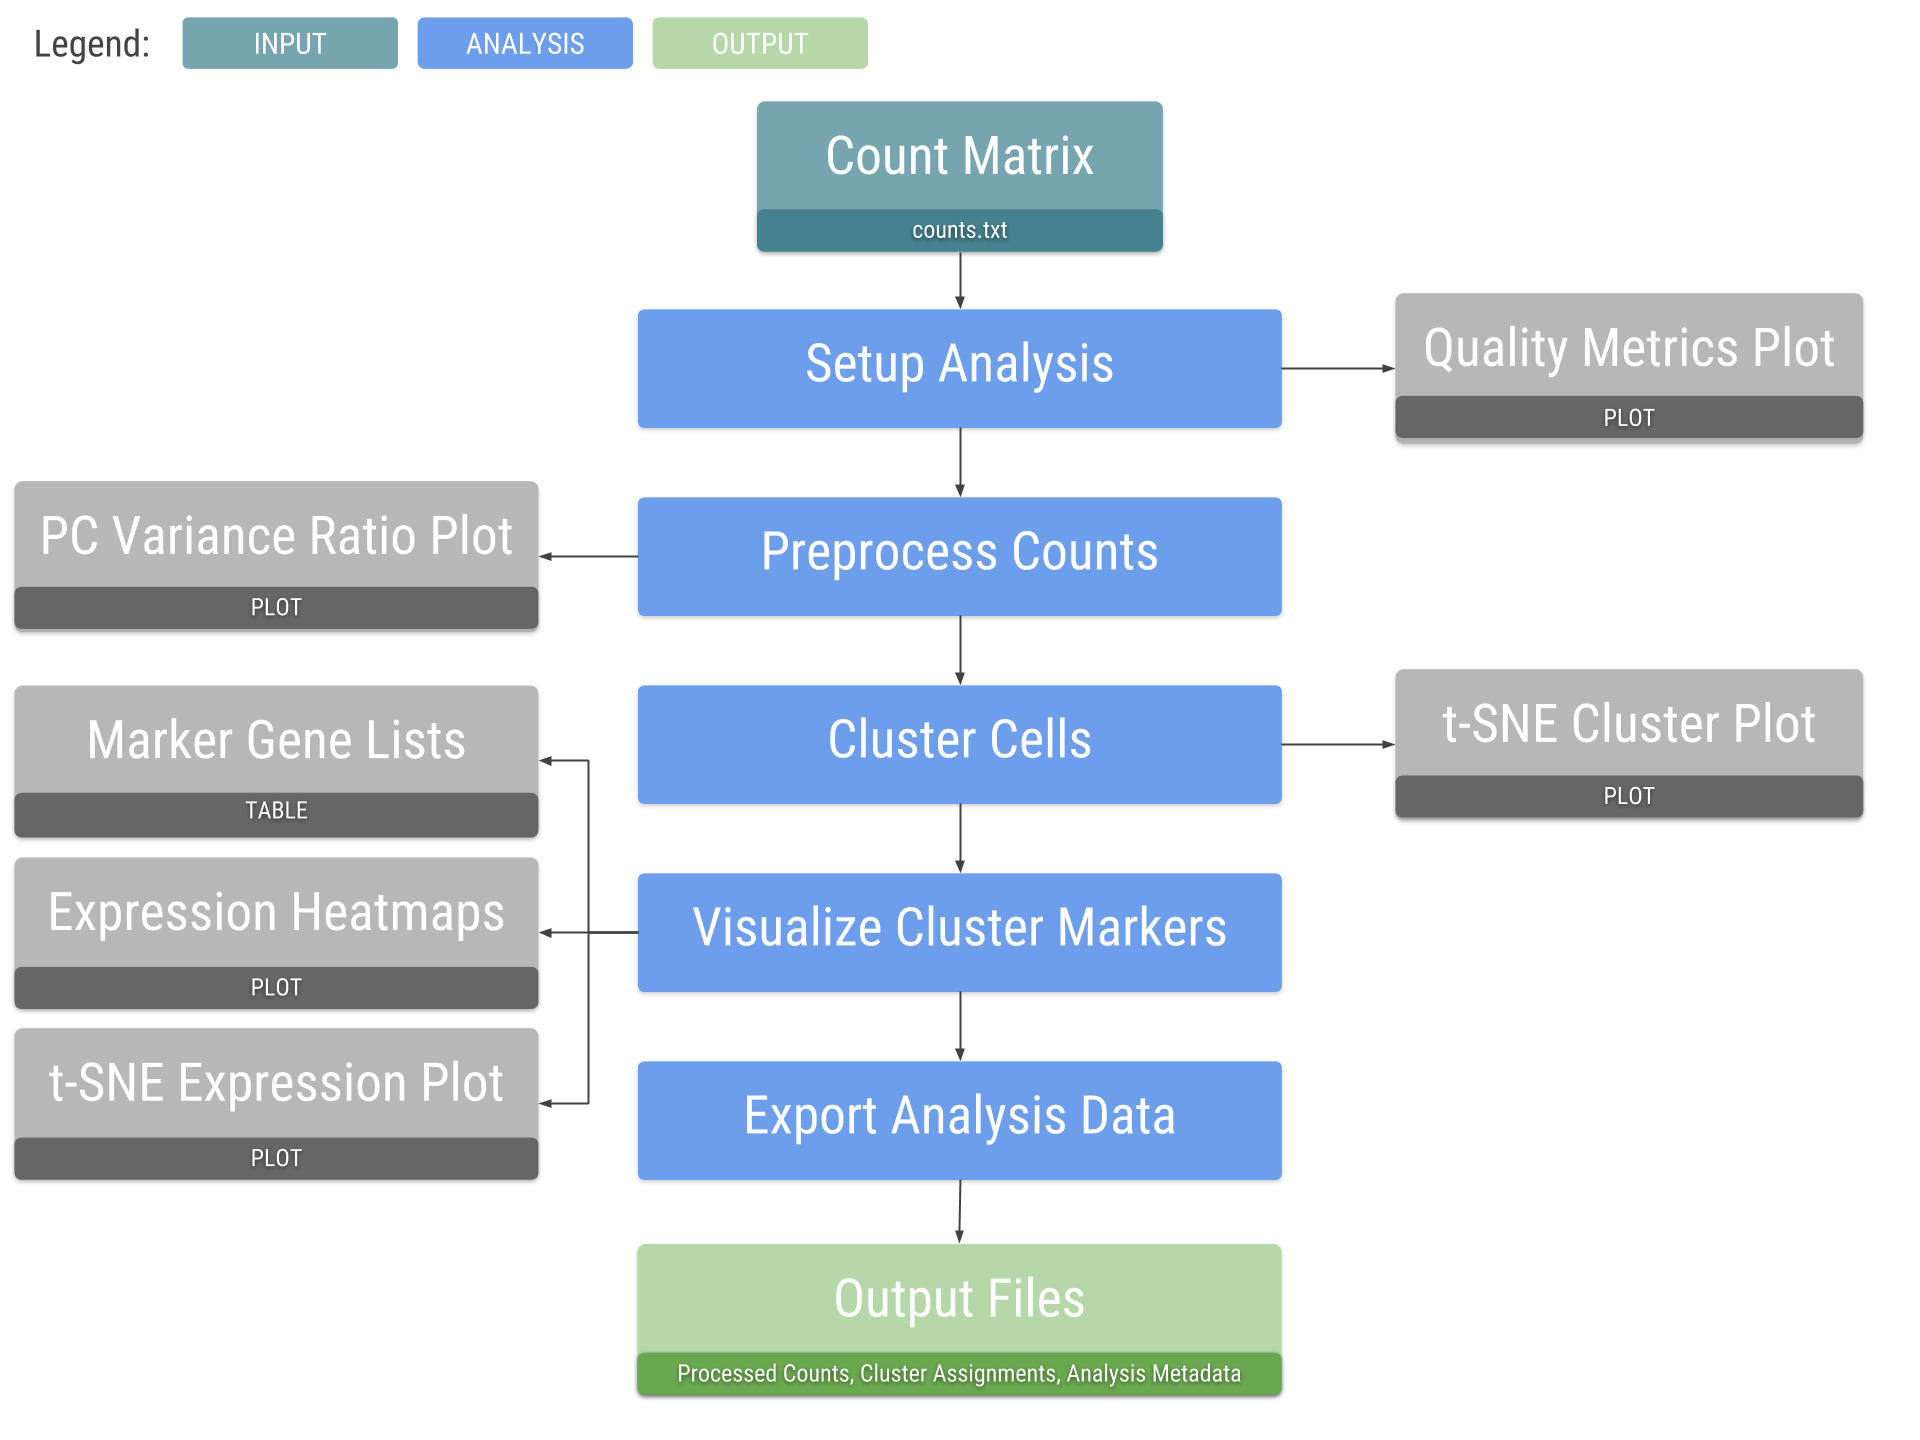
[diagram source](https://docs.google.com/presentation/d/1NV1_FewyUpslrijAOD8bOfaJXveT6lImfTYFnkuVjHM/edit?usp=sharing)

## Table of Contents
1. [**Setup Analysis**](#Step-1:-Setup-Analysis)
    1. Load raw count matrix.
2. [**Preprocess Counts**](#Step-2:-Preprocess-Counts)
    1. Filter cells based on QC metrics.
    2. Perform log scaling and normalization to total counts.
    3. Remove unwanted sources of variation (number of detected molecules per cell as well as the percentage mitochondrial gene content).
    4. Detect highly variable genes.
    5. Perform linear dimensional reduction (PCA).
3. [**Cluster Cells**](#Step-3:-Cluster-Cells)
    1. Cluster cells (graph-based clustering) in PCA space and visualize using t-SNE.
4. [**Visualize Cluster Markers**](#Step-4:-Visualize-Cluster-Markers)
    1. Explore and visualize cluster markers interactively.
5. [**Export Analysis Data**](#Step-5:-Export-Analysis-Data)
    1. Export data to `.csv` files or a compressed `.h5ad` format.

# Step 1: Setup Analysis

<p>Load a raw count matrix for a single-cell RNA-seq experiment. </p>

<p><b>Supported file formats</b>: `csv`, `txt`, `tsv`, `tab`, `data`, `h5`, `h5ad`, `loom`, `mtx*`</p>

<p><b>Text and Excel files</b> (csv, txt, tsv, tab, data): Gene and sample names are assumed to be the first column and row respectively.</p>

<p><b>NOTE</b>: The 10x Genomics genomics pipeline generates gene-barcode matrices usually named `matrix.mtx`, `genes.tsv`, and `barcodes.tsv`. If the `mtx` files is provided, the genes and barcodes files will autoomatically be imported from the same folder.</p>

<div class="alert alert-info">
<h3 style="margin-top: 0;"> Instructions <i class="fa fa-info-circle"></i></h3>
<ol><li>Provide your data file either as a URL or local file path. Select "2700 PBMCs from a Healthy Donor (example)" from the dropdown menu to load the example dataset.</li></ol>
</div>
<br>
<div class="well well-sm">
<p>**Estimated run time**: < 1 minute </p>
</div>

In [ ]:
# Workaround for bug in GPNB 0.7.2
from IPython.display import display, Javascript
display(Javascript("""
setTimeout(function() {
    $(".gp-widget-call").each(function(i, e) {
        const widget = $(e).data("widget");
        widget.options.append_output = false;
    })
}, 1000);
"""))

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import sys
sys.path.append('.')

import genepattern
from singlecell import SingleCellAnalysis, sc
import logging
sc.settings.verbosity = 0
logging.disable(logging.INFO)

%matplotlib inline

# Workaround for bug in GPNB 0.7.2
from IPython.display import display, Javascript
display(Javascript("""
setTimeout(function() {
    $(".gp-widget-call").each(function(i, e) {
        const widget = $(e).data("widget");
        widget.options.append_output = false;
    })
}, 1000);
"""))

analysis = SingleCellAnalysis()
genepattern.GPUIBuilder(
    analysis.setup_analysis,
    function_import='analysis.setup_analysis',
    name='Setup Analysis',
    parameters={
        'matrix_filepath': {
            'name': 'matrix data file',
            'description': 'Provide your data file either as a URL or local file path. See above instructions for supported formats.',
            'default': 'https://github.com/genepattern/single_cell_clustering_notebook/raw/master/data/matrix.mtx',
            'type': 'file',
            'choices': {'2700 PBMCs from a Healthy Donor (example)': 'https://github.com/genepattern/single_cell_clustering_notebook/raw/master/data/matrix.mtx'},
            'kinds': ['csv', 'xlsx', 'txt', 'tsv', 'tab', 'data', 'h5', 'h5ad', 'soft.gz', 'txt.gz', 'anndata', 'mtx'],
        },
        'output_var': {
            'hide': True
        }
    }
)

# Step 2: Preprocess Counts

<p>Perform cell quality control by filtering based on quality metrics, log normalizing counts, scaling by total counts, and correcting for effects of total counts per cell and the percentage of mitochondrial genes expressed. Finally, detect highly variable genes and perform linear dimensional reduction (PCA).</p>

<div class="alert alert-info">
<h3 style="margin-top: 0;">Instructions <i class="fa fa-info-circle"></i></h3>
<ol><li>Use the quality metrics displayed in the output of **Step 1** to visually identify thresholds for filtering unwanted cells.</li></ol>
</div>
<br>
<div class="well well-sm">**Estimated run time:** < 1 minute</div>

In [ ]:
genepattern.GPUIBuilder(
    analysis.preprocess_counts,
    function_import='analysis.preprocess_counts',
    name='Preprocess Counts',
    parameters={
        'data': {
            'description': 'Output from the "Setup Analysis" tool.',
            'default': 'analysis'
        },
        
        'min_n_cells': {
            'name': 'filter genes (min. # of cells)',
            'description': 'Include genes expressed in at least this many cells. Blank will be treated as 0.',
            'type': 'number',
            'default': 3
        },
        
        'min_n_genes': {
            'name': 'filter cells (min. # of genes)',
            'description': 'Include cells with at least this many genes. Blank will be treated as 0.',
            'type': 'number',
            'default': 200
        },
        'max_n_genes': {
            'name': 'filter cells (max # of genes)',
            'description': 'Include cells with at most this many genes. Blank will be treated as no maximum value.',
            'type': 'number',
            'default': 1700
        },
        'min_n_counts': {
            'name': 'filter cells (min. total counts)',
            'description': 'Include cells with at least this many counts. Blank will be treated as 0.',
            'type': 'number',
            'default': 0
        },
        'max_n_counts': {
            'name': 'filter cells (max total counts)',
            'description': 'Include cells with at most this many counts. Blank will be treated as no maximum value.',
            'type': 'number',
            'default': 5700
        },
        'min_percent_mito': {
            'name': 'filter cells (min. % mito. genes)',
            'description': 'Include cells with at least this % of reads mapped to mitochondrial genes. Blank will be treated as 0.',
            'type': 'number',
            'default': 0
        },
        'max_percent_mito': {
            'name': 'filter cells (max % mito. genes)',
            'description': 'Include cells with at most this % of reads mapped to mitochondrial genes. Blank will be treated as no maximum value.',
            'type': 'number',
            'default': 6
        },
        'normalization_method': {
            'name': 'log normalize',
            'description': 'Perform log normalization on the data.',
            'choices': {'Yes': 'LogNormalize', 'No': ''}
        },
        'output_var': {
            'hide': True
        }
    })

# Step 3: Cluster Cells

<p>Cluster cells using the Louvain method for community detection on `N` principal components. Then use t-SNE to visualize cells, using `N` principal components.</p>

It is important to note that the fewer PCs we choose to use, the less noise we have when clustering, but at the risk of excluding relevant biological variance. Look at the plot in **Step 2** showing the percent variance explained by each principle component and choose a cutoff where there is a clear elbow in the graph. The `N` principal components to the left of this cutoff are then used to cluster the cells.

<div class="alert alert-info">
<h3 style="margin-top: 0;">Instructions <i class="fa fa-info-circle"></i></h3>
<ol><li>Perform clustering and visualization of the cells using the sliders to tune parameters.</li></ol>
</div>
<br>
<div class="well well-sm">**Estimated run time:** < 2 minutes (for 2600 cells x 10 principal components)</div>

In [ ]:
genepattern.GPUIBuilder(
    analysis.cluster_cells,
    function_import='analysis.cluster_cells',
    name='Open Cell Clustering Interface',
    description='This step outputs an interactive interface to cluster cells.',
    parameters={
        'output_var': {
            'hide': True
        }
    })

# Step 4: Visualize Cluster Markers

Visualization the expression of markers on the clustering plot.

Explore genes that are differentially expressed in clusters as potential biomarkers. We provide the Wilcoxon rank-sum test (default) and t-test as test options. The non-parametric Wilcoxon rank-sum test generally performs better for single-cell data since single-cell counts are usually not normally distributed, which the t-test assumes. The Wilcoxon rank-sum test is also less sensitive to outliers.

<p>The following are canonical markers that mark known cell types in this dataset. These can be used to identify what cell types are present and how they correspond to clusters.</p>

| Cell Type | Markers |
| --------- | ------- |
| CD4 T Cells | IL7R |
| LYZCD14+ Monocytes | CD14, LYZ |
| B cells | MS4A1 |
| CD8 T cells | CD8A |
| FCGR3A+ Monocytes | FCGR3A, MS4A7 |
| NK cells | GNLY, NKG7 |
| Dendritic Cells | FCER1A, CST3 |
| Megakaryocytes | PPBP |

<div class="alert alert-info">
<h3 style="margin-top: 0;">Instructions <i class="fa fa-info-circle"></i></h3>
<ol>
    <li>Examine the heatmap to understand how distinct each cluster is compared to others. Modify parmaters to show more top markers or change the statistical test.</li>
    <li>Use the **Explore Markers** panel to identify differentially expressed genes.
        <ol><li>See panel instructions to export gene lists.</li></ol>
    </li>
    <li>See the **tSNE Plot** panel to visualize gene expression across clusters.</li>
</ol>
</div>


In [ ]:
genepattern.GPUIBuilder(
    analysis.visualize_markers,
    function_import='analysis.visualize_markers',
    name='Open Visualize Cluster Markers Interface',
    description='This step outputs an interactive interface to explore gene expression in clusters of cells.',
    parameters={
        'output_var': {
            'hide': True
        }
    }
)

# Step 5: Export Analysis Data

<h4 style="margin-top:0;">Relevant Files</h4>
<p>
<ul>
    <li><code>X.csv</code> - The preprocessed expression matrix of cells (rows) by genes (columns). This only includes variable genes, usually a much smaller subset of genes compared to the raw counts.</li>
    <li><code>obs.csv</code> - Cell annotations including # of genes, % mitochondrial genes,  and cluster assignments</li>
    <li><code>obsm.csv</code> - Coordinates of cells in various dimensional reduction spaces (e.g., PCA, t-SNE).</li>
    <li><code>var.csv</code> - Gene annotations (of variable genes) including the # of cells, mean expression, dispersion, and normalized dispersion statistics.</li>
    <li><code>varm.csv</code> - Loadings of cells in various dimensional reduction spaces (e.g., PCA, t-SNE).
</li>
    <li><code>uns/pca_variance_ratio.csv</code> - % variance explained by each principal component.</li>
    <li><code>uns/rank_genes_groups_gene_names.csv</code> - Names of the top ranked marker genes for each cluster.</li>
    <li><code>uns/rank_genes_groups_gene_scores.csv</code> - z-scores of the top ranked marker genes for each cluster.</li>
</ul>
</p>

<div class="alert alert-info">
<h3 style="margin-top: 0;">Instructions <i class="fa fa-info-circle"></i></h3>
<p>Using the cell below, export results as a series of <code>.csv</code> files or compressed <code>.h5ad</code> file. The files will create and appear in <a href="data/">the data folder by default.</a></p>
</div>
<br>
<div class="well well-sm">**Estimated run time:** < 30 seconds</div>

In [ ]:
genepattern.GPUIBuilder(
    analysis.export_data,
    function_import='analysis.export_data',
    name='Export Analysis Data',
    description='Export data as a series of .csv files or compressed .hda5 file.',
    parameters={
        'path': {
            'name': 'filepath',
            'description': 'Name of directory where file(s) will be saved. Exporting as an h5ad file produces a single file output.',
            'default': 'data/analysis'
        },
        'h5ad': {
            'name': 'file format',
            'description': 'Choose to save either as .csv files or as a single compressed .h5ad-formatted hdf5 file. It is recommended to export .csv files unless you know what you are doing.',
            'default': False,
            'choices': {
                'Comma-separated values (.csv)': False,
                'H5AD file (HDF5 file in the AnnData formatting convention)': True
            },
        },
        'output_var': {
            'hide': True
        }
    }
)

# Results Interpretation

This analysis employs a scRNA-seq gene expression dataset for 2700 peripheral blood mononuclear cells (PBMCs) from a healthy donor as a demonstration of its use. We are able to recapitulate cell types; the clusters can be characterized by visualizing the expression of canonical markers of these cell types on the 2D t-SNE projection plot as done in [Step 3](#Step-3:-Cluster-Cells) and [Step 4](#Step-4:-Visualize-Cluster-Markers).

In [Step 4](#Step-4:-Visualize-Cluster-Markers), the visualization of cluster marker expression helps us understand why some cells we identify visually as a single cluster are divided into multiple. For example, [LYZ](https://ghr.nlm.nih.gov/gene/LYZ) is overexpressed in a cloud of samples that clustering separates as two distinct clusters. The LYZ gene encodes for human lysozyme, an antimicrobial agent associated with blood monocytes. Using the cluster comparison tool, we can see that one of the subclusters exhibits high relative expression of [CD14](https://ghr.nlm.nih.gov/gene/NDUFA2) while the other exhibits high relative expression of [FCGR3A](https://ghr.nlm.nih.gov/gene/FCGR3A), also known as the CD16 receptor gene. These two genes characterize two known subtypes of blood monocytes respectively; classical and non-classical monocytes.

# References

1. Satija, R., Farrell, J. A., Gennert, D., Schier, A. F., & Regev, A. (2015). Spatial reconstruction of single-cell gene expression data. *Nature Biotechnology*, 33, 495. http://dx.doi.org/10.1038/nbt.3192

2. Wolf, F. A., Angerer, P., & Theis, F. J. (2018). SCANPY: large-scale single-cell gene expression data analysis. *Genome Biology*, 19(1), 15. https://doi.org/10.1186/s13059-017-1382-0